Implementation of 2D elasto-plastic problem using FEniCS-X. The code is based on a [legacy solution](https://comet-fenics.readthedocs.io/en/latest/demo/2D_plasticity/vonMises_plasticity.py.html) for FEniCS 2019.

The program was tested for 0.3.1.0 version of Dolfinx.

In [1]:
#TODO https://github.com/FEniCS/dolfinx/blob/main/python/test/unit/fem/test_expression.py

In [2]:
import meshio
import numpy as np

import ufl
from dolfinx import fem, io
from mpi4py import MPI
from petsc4py import PETSc
from dolfinx.geometry import (BoundingBoxTree, compute_colliding_cells, compute_collisions)
import time
import basix

def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    cell_data = mesh.get_cell_data("gmsh:physical", cell_type)
    points = mesh.points[:,:2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells}, cell_data={"name_to_read":[cell_data]})
    return out_mesh

# defining function to interpolate function defined over quadrature elements
def interpolate_quadrature(ufl_expr, fem_func):
    q_dim = fem_func.function_space._ufl_element.degree()
    mesh = fem_func.ufl_function_space().mesh
    
    basix_celltype = getattr(basix.CellType, mesh.topology.cell_type.name)
    quadrature_points, weights = basix.make_quadrature(basix_celltype, q_dim)
    map_c = mesh.topology.index_map(mesh.topology.dim)
    num_cells = map_c.size_local + map_c.num_ghosts
    cells = np.arange(0, num_cells, dtype=np.int32)

    expr_expr = fem.Expression(ufl_expr, quadrature_points)
    expr_eval = expr_expr.eval(cells)
    fem_func.x.array[:] = expr_eval.flatten()[:]
    fem_func.x.scatter_forward()

In [3]:
if MPI.COMM_WORLD.rank == 0:

    #It works with the msh4 only!!
    msh = meshio.read("thick_cylinder.msh")

    # Create and save one file for the mesh, and one file for the facets 
    triangle_mesh = create_mesh(msh, "triangle", prune_z=True)
    line_mesh = create_mesh(msh, "line", prune_z=True)
    meshio.write("thick_cylinder.xdmf", triangle_mesh)
    meshio.write("mt.xdmf", line_mesh)
    print(msh)
    


<meshio mesh object>
  Number of points: 811
  Number of cells:
    line: 10
    line: 69
    line: 10
    line: 53
    triangle: 1478
  Cell sets: gmsh:bounding_entities
  Point data: gmsh:dim_tags
  Cell data: gmsh:physical, gmsh:geometrical


In [4]:
with io.XDMFFile(MPI.COMM_WORLD, "thick_cylinder.xdmf", "r") as xdmf:
    mesh = xdmf.read_mesh(name="Grid")
    ct = xdmf.read_meshtags(mesh, name="Grid")

mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim - 1)

with io.XDMFFile(MPI.COMM_WORLD, "mt.xdmf", "r") as xdmf:
    ft = xdmf.read_meshtags(mesh, name="Grid")

In [5]:
# elastic parameters
E = 70e3
nu = 0.3
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = fem.Constant(mesh, PETSc.ScalarType(E/2./(1+nu)))
sig0 = fem.Constant(mesh, PETSc.ScalarType(250))  # yield strength
Et = E/100.  # tangent modulus
H = E*Et/(E-Et)  # hardening modulus

Re, Ri = 1.3, 1.   # external/internal radius

In [6]:
deg_u = 2
deg_stress = 2
V = fem.VectorFunctionSpace(mesh, ("CG", deg_u))
We = ufl.VectorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, dim=4, quad_scheme='default')
W0e = ufl.FiniteElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, quad_scheme='default')
W = fem.FunctionSpace(mesh, We)
W0 = fem.FunctionSpace(mesh, W0e)

In [7]:
sig = fem.Function(W)
sig_old = fem.Function(W)
n_elas = fem.Function(W)
beta = fem.Function(W0)
p = fem.Function(W0, name="Cumulative_plastic_strain")
dp = fem.Function(W0)
u = fem.Function(V, name="Total_displacement")
du = fem.Function(V, name="Iteration_correction")
Du = fem.Function(V, name="Current_increment")
v = ufl.TrialFunction(V)
u_ = ufl.TestFunction(V)

P0 = fem.FunctionSpace(mesh, ("DG", 0))
p_avg = fem.Function(P0, name="Plastic_strain")

zero_Du = fem.Function(V)

In [8]:
left_marker = 3
down_marker = 1
left_facets = ft.indices[ft.values == left_marker]
down_facets = ft.indices[ft.values == down_marker]
left_dofs = fem.locate_dofs_topological(V.sub(0), mesh.topology.dim-1, left_facets)
down_dofs = fem.locate_dofs_topological(V.sub(1), mesh.topology.dim-1, down_facets)

bcs = [fem.dirichletbc(PETSc.ScalarType(0), left_dofs, V.sub(0)), fem.dirichletbc(PETSc.ScalarType(0), down_dofs, V.sub(1))]

In [9]:
n = ufl.FacetNormal(mesh)
q_lim = float(2/np.sqrt(3)*np.log(Re/Ri)*sig0.value)

# class Loading:
#     def __init__(self):
#         self.q = q_lim
#         self.t = 0.0

#     def eval(self, x):
#         return np.full(x.shape[1], -self.q * self.t)

# loading = Loading()
# load_func.interpolate(loading.eval)
V_real = fem.FunctionSpace(mesh, ("CG", deg_u))
loading = fem.Function(V_real)

# loading.interpolate(lambda x: (np.zeros_like(x[1])))
# loading.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

def F_ext(v):
    return -loading * ufl.inner(n, v)*ds(4)

def eps(v):
    e = ufl.sym(ufl.grad(v))
    return ufl.as_tensor([[e[0, 0], e[0, 1], 0],
                          [e[0, 1], e[1, 1], 0],
                          [0, 0, 0]])
def sigma(eps_el):
    return lmbda*ufl.tr(eps_el)*ufl.Identity(3) + 2*mu*eps_el

def as_3D_tensor(X):
    return ufl.as_tensor([[X[0], X[3], 0],
                          [X[3], X[1], 0],
                          [0, 0, X[2]]])

ppos = lambda x: (x + ufl.sqrt(x**2))/2.
def proj_sig(deps, old_sig, old_p):
    sig_n = as_3D_tensor(old_sig)
    sig_elas = sig_n + sigma(deps)
    s = ufl.dev(sig_elas)
    sig_eq = ufl.sqrt(3/2.*ufl.inner(s, s))
    f_elas = sig_eq - sig0 - H*old_p
    dp = ppos(f_elas)/(3*mu+H)
    n_elas = s/sig_eq*ppos(f_elas)/f_elas
    beta = 3*mu*dp/sig_eq
    new_sig = sig_elas-beta*s
    return ufl.as_vector([new_sig[0, 0], new_sig[1, 1], new_sig[2, 2], new_sig[0, 1]]), \
           ufl.as_vector([n_elas[0, 0], n_elas[1, 1], n_elas[2, 2], n_elas[0, 1]]), \
           beta, dp         

def sigma_tang(e):
    N_elas = as_3D_tensor(n_elas)
    return sigma(e) - 3*mu*(3*mu/(3*mu+H)-beta)*ufl.inner(N_elas, e)*N_elas - 2*mu*beta*ufl.dev(e)  

In [10]:
ds = ufl.Measure("ds", domain=mesh, subdomain_data=ft)
dx = ufl.Measure(
    "dx",
    domain=mesh,
    metadata={"quadrature_degree": deg_stress, "quadrature_scheme": "default"},
)

a_Newton = ufl.inner(eps(v), sigma_tang(eps(u_)))*dx
res = -ufl.inner(eps(u_), as_3D_tensor(sig))*dx + F_ext(u_)

def project(original_field, target_field, bcs=[]):
    # original_field -> target_field
    # Ensure we have a mesh and attach to measure
    V = target_field.function_space

    # Define variational problem for projection
    w = ufl.TestFunction(V)
    Pv = ufl.TrialFunction(V)
    a = fem.form(ufl.inner(Pv, w) * dx)
    L = fem.form(ufl.inner(original_field, w) * dx)

    # Assemble linear system
    A = fem.petsc.assemble_matrix(a, bcs)
    A.assemble()
    b = fem.petsc.assemble_vector(L)
    fem.petsc.apply_lifting(b, [a], [bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, bcs)

    # Solve linear system
    solver = PETSc.KSP().create(A.getComm())
    solver.setOperators(A)
    solver.solve(b, target_field.vector)  
    target_field.x.scatter_forward()


In [11]:
problem = fem.petsc.LinearProblem(
    a_Newton,
    res,
    bcs=bcs,
    petsc_options={
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
)

In [12]:
# Defining a cell containing (Ri, 0) point, where we calculate a value of u

cells = []
points_on_proc = []
x_point = np.zeros((1, 3))
x_point[0][0] = Ri
tree = BoundingBoxTree(mesh, mesh.geometry.dim)
cell_candidates = compute_collisions(tree, x_point)
colliding_cells = compute_colliding_cells(mesh, cell_candidates, x_point)
for i, point in enumerate(x_point):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])

In [13]:
Nitermax, tol = 200, 1e-8  # parameters of the Newton-Raphson procedure
Nincr = 20
load_steps = np.linspace(0, 1.1, Nincr+1)[1:]**0.5
results = np.zeros((Nincr+1, 2))
xdmf = io.XDMFFile(MPI.COMM_WORLD, "plasticity.xdmf", "w", encoding=io.XDMFFile.Encoding.HDF5)
xdmf.write_mesh(mesh)

start = time.time()

for (i, t) in enumerate(load_steps):
    # loading.t = t
    # load_func.interpolate(loading.eval)
    loading.interpolate(lambda x: (t * q_lim * np.ones_like(x[1])))
    loading.x.scatter_forward()

    Res0 = fem.petsc.assemble_vector(fem.form(res))
    Res0.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    fem.set_bc(Res0, bcs, du.vector)

    nRes0 = Res0.norm() # Which one? - ufl.sqrt(Res.dot(Res))
    nRes = 1
    zero_Du.vector.copy(Du.vector)
    Du.x.scatter_forward()
    if MPI.COMM_WORLD.rank == 0:
        print(f"nRes0 , {nRes0} \n Increment: {str(i+1)}, load = {t * q_lim}")
    niter = 0
     
    while nRes/nRes0 > tol and niter < Nitermax:
        du = problem.solve()
        du.x.scatter_forward() 

        Du.vector.axpy(1, du.vector) # Du = Du + 1*du
        Du.x.scatter_forward() 

        deps = eps(Du)
        sig_, n_elas_, beta_, dp_ = proj_sig(deps, sig_old, p)

        # project(sig_, sig)
        # project(n_elas_, n_elas)
        # project(beta_, beta)
        interpolate_quadrature(sig_, sig)
        interpolate_quadrature(n_elas_, n_elas)
        interpolate_quadrature(beta_, beta)

        Res = fem.petsc.assemble_vector(fem.form(res))
        Res.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        fem.set_bc(Res, bcs, du.vector)

        nRes = Res.norm() 
        if MPI.COMM_WORLD.rank == 0:
            print(f"    Residual: {nRes}")
        niter += 1
    u.vector.axpy(1, Du.vector) # u = u + 1*Du
    u.x.scatter_forward()

    sig.vector.copy(sig_old.vector)
    sig.x.scatter_forward()

    # project(dp_, dp)
    interpolate_quadrature(dp_, dp)
    p.vector.axpy(1, dp.vector)
    p.x.scatter_forward()

    project(p, p_avg)
    # interpolate_quadrature(p, p_avg)
    p_avg.x.scatter_forward()
    
    xdmf.write_function(u, t)
    xdmf.write_function(p_avg, t)

    if len(points_on_proc) > 0:
        results[i+1, :] = (u.eval(points_on_proc, cells)[0], t)

xdmf.close()
end = time.time()
print(f'rank#{MPI.COMM_WORLD.rank}: Time = {end-start:.3f} (s)')

nRes0 , 2.85368238440022 
 Increment: 1, load = 17.7621446711497
    Residual: 3.5986867330344404e-12
nRes0 , 1.1820339463237637 
 Increment: 2, load = 25.119465890772904
    Residual: 1.4779823405049433e-12
nRes0 , 0.9070065477214541 
 Increment: 3, load = 30.764937021820067
    Residual: 1.1366423843694714e-12
nRes0 , 0.7646418903549145 
 Increment: 4, load = 35.5242893422994
    Residual: 9.597922952993475e-13
nRes0 , 0.6736630289121138 
 Increment: 5, load = 39.717362910876375
    Residual: 8.532596121932003e-13
nRes0 , 0.6090379320367267 
 Increment: 6, load = 43.50819118181207
    Residual: 7.665703443740573e-13
nRes0 , 0.5600681801393694 
 Increment: 7, load = 46.99421755101324
    Residual: 7.013589968978524e-13
nRes0 , 0.5212987515591537 
 Increment: 8, load = 50.23893178154581
    Residual: 6.545878613294919e-13
nRes0 , 0.48961449175264043 
 Increment: 9, load = 53.286434013449096
    Residual: 6.144963001855129e-13
nRes0 , 0.4630889002041811 
 Increment: 10, load = 56.168833

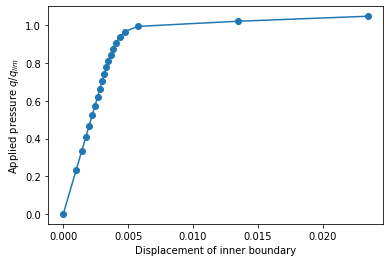

In [28]:
if len(points_on_proc) > 0:
    import matplotlib.pyplot as plt
    plt.plot(results[:, 0], results[:, 1], "-o")
    plt.xlabel("Displacement of inner boundary")
    plt.ylabel(r"Applied pressure $q/q_{lim}$")
    plt.savefig(f"displacement_rank{MPI.COMM_WORLD.rank:d}.png")
    plt.show()

In [32]:
u.x

In [31]:
u.vector

In [ ]:
  # A.zeroEntries()
    # fem.petsc.assemble_matrix(A, fem.form(a_Newton), bcs=bcs)
    # A.assemble()

    # Res0 = fem.petsc.assemble_vector(fem.form(res))
    # with Res0.localForm() as loc_b:
    #     loc_b.set(0.)
    # fem.petsc.assemble_vector(Res0, fem.form(res))
    # Res0.assemble()

    # fem.petsc.apply_lifting(Res0, [fem.form(a_Newton)], [bcs], x0=[Du.vector], scale=-1.0)
    # Res0.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    # fem.petsc.set_bc(Res, bcs, Du.vector, -1.0)

    # solver.setOperators(A)

In [ ]:
# Res.array.shape

In [ ]:
Nitermax, tol = 200, 1e-8  # parameters of the Newton-Raphson procedure
Nincr = 20
load_steps = np.linspace(0, 1.1, Nincr+1)[1:]**0.5
results = np.zeros((Nincr+1, 2))
t = load_steps[0]
i = 0
for (i, t) in enumerate(load_steps):
    # loading.t = t
    # load_func.interpolate(loading.eval)
    loading.interpolate(lambda x: (t * q_lim * np.ones_like(x[1])))
    loading.vector.ghostUpdate(
        addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD
    )
    # A, Res = assemble_system(a_Newton, res, bcs)
    fem.petsc.assemble_matrix(A, fem.form(a_Newton), bcs=bcs)
    A.assemble()
    # fem.petsc.assemble_vector(Res, fem.form(res))
    with Res.localForm() as loc_b:
        loc_b.set(0)
    # Res.assemble()
    fem.petsc.assemble_vector(Res, fem.form(res))

    fem.petsc.apply_lifting(Res, [fem.form(a_Newton)], [bcs])
    Res.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(Res, bcs)
    # uh = fem.Function(V)
    print(Res.array.max())
    nRes0 = Res.norm() # Which one?
    nRes = 1
    # zero_Du.vector.copy(Du.vector)
    # Du.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    # Du.interpolate(lambda x : (np.zeros_like(x[0]), np.zeros_like(x[1])))
    # Du.interpolate(fem.Constant(mesh, (ScalarType(0), ScalarType(0))))
    print("Increment:", str(i+1), t * q_lim)
    niter = 0
        
    while nRes > tol and niter < Nitermax:
        # du = problem.solve()
        print(du.vector.max())
        solver.solve(Res, du.vector) #, "mumps"
        du.x.scatter_forward() 
        print(du.vector.min())

        # Du.assign(Du+du)
        Du.vector.axpy(1, du.vector) # Du = Du + 1*du
        Du.x.scatter_forward() 

        deps = eps(Du)
        sig_, n_elas_, beta_, dp_ = proj_sig(deps, sig_old, p)
        # local_project(sig_, W, sig)
        # local_project(n_elas_, W, n_elas)
        # local_project(beta_, W0, beta)
        # print(sig_, '\n', sig)
        project(sig_, sig)
        project(n_elas_, n_elas)
        project(beta_, beta)
        
        # A, Res = assemble_system(a_Newton, res, bcs)

        # fem.petsc.assemble_matrix(A, fem.form(a_Newton), bcs=bcs)
        # A.assemble()
        fem.petsc.assemble_vector(Res, fem.form(res))
        # with Res.localForm() as loc_b:
        #     loc_b.set(0)
        Res.assemble()

        fem.petsc.apply_lifting(Res, [fem.form(a_Newton)], [bcs])
        Res.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        fem.petsc.set_bc(Res, bcs)

        nRes = Res.norm()
        print("    Residual:", nRes, dp.vector.max())
        niter += 1
    # u.assign(u+Du)
    u.vector.axpy(1, Du.vector) # u = u + 1*Du
    u.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

    # sig_old.assign(sig)
    # p.assign(p+local_project(dp_, W0))
    sig.vector.copy(sig_old.vector)
    sig_old.vector.ghostUpdate(
        addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD
    )
    project(dp_, dp)
    p.vector.axpy(1, dp.vector)
    p.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)


In [24]:
Nitermax, tol = 200, 1e-8  # parameters of the Newton-Raphson procedure
Nincr = 20
load_steps = np.linspace(0, 1.1, Nincr+1)[1:]**0.5
results = np.zeros((Nincr+1, 2))
for (i, t) in enumerate(load_steps):
    # loading.t = t
    # load_func.interpolate(loading.eval)
    loading.interpolate(lambda x: (t * q_lim * np.ones_like(x[1])))
    loading.vector.ghostUpdate(
        addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD
    )
    # A, Res = assemble_system(a_Newton, res, bcs)
    fem.petsc.assemble_matrix(A, fem.form(a_Newton), bcs=bcs)
    A.assemble()
    # fem.petsc.assemble_vector(Res, fem.form(res))
    with Res.localForm() as loc_b:
        loc_b.set(0)
    # Res.assemble()
    fem.petsc.assemble_vector(Res, fem.form(res))

    fem.petsc.apply_lifting(Res, [fem.form(a_Newton)], [bcs])
    Res.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(Res, bcs)
    # uh = fem.Function(V)
    nRes0 = Res.norm() # Which one?
    nRes = 1
    # zero_Du.vector.copy(Du.vector)
    # Du.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
    # Du.interpolate(lambda x : (np.zeros_like(x[0]), np.zeros_like(x[1])))
    # Du.interpolate(fem.Constant(mesh, (ScalarType(0), ScalarType(0))))
    print("Increment:", str(i+1), t * q_lim)
    niter = 0
     
    while nRes > tol and niter < Nitermax:
        # du = problem.solve()
        print(du.vector.max())
        solver.solve(Res, du.vector) #, "mumps"
        du.x.scatter_forward() 
        print(du.vector.min())

        # Du.assign(Du+du)
        Du.vector.axpy(1, du.vector) # Du = Du + 1*du
        Du.x.scatter_forward() 

        deps = eps(Du)
        sig_, n_elas_, beta_, dp_ = proj_sig(deps, sig_old, p)
        # local_project(sig_, W, sig)
        # local_project(n_elas_, W, n_elas)
        # local_project(beta_, W0, beta)
        # print(sig_, '\n', sig)
        project(sig_, sig)
        project(n_elas_, n_elas)
        project(beta_, beta)
        
        # A, Res = assemble_system(a_Newton, res, bcs)

        # fem.petsc.assemble_matrix(A, fem.form(a_Newton), bcs=bcs)
        # A.assemble()
        fem.petsc.assemble_vector(Res, fem.form(res))
        # with Res.localForm() as loc_b:
        #     loc_b.set(0)
        Res.assemble()

        fem.petsc.apply_lifting(Res, [fem.form(a_Newton)], [bcs])
        Res.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        fem.petsc.set_bc(Res, bcs)

        nRes = Res.norm()
        print("    Residual:", nRes, dp.vector.max())
        niter += 1
    # u.assign(u+Du)
    u.vector.axpy(1, Du.vector) # u = u + 1*Du
    u.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

    # sig_old.assign(sig)
    # p.assign(p+local_project(dp_, W0))
    sig.vector.copy(sig_old.vector)
    sig_old.vector.ghostUpdate(
        addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD
    )
    project(dp_, dp)
    p.vector.axpy(1, dp.vector)
    p.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)


Increment: 1 25.119465890772904
(0, 0.0)
(0, 0.0)
    Residual: 0.0 (0, 0.0)
Increment: 2 35.5242893422994
(0, 0.0)
(0, 0.0)
    Residual: 0.0 (0, 0.0)
Increment: 3 43.50819118181207
(0, 0.0)
(0, 0.0)
    Residual: 0.0 (0, 0.0)
Increment: 4 50.23893178154581
(0, 0.0)
(0, 0.0)
    Residual: 0.0 (0, 0.0)
Increment: 5 56.16883329025551
(0, 0.0)
(0, 0.0)
    Residual: 0.0 (0, 0.0)
Increment: 6 61.529874043640135
(0, 0.0)
(0, 0.0)
    Residual: 0.0 (0, 0.0)
Increment: 7 66.45985981375466
(0, 0.0)
(0, 0.0)
    Residual: 0.0 (0, 0.0)
Increment: 8 71.0485786845988
(0, 0.0)
(0, 0.0)
    Residual: 0.0 (0, 0.0)
Increment: 9 75.3583976723187
(0, 0.0)
(0, 0.0)
    Residual: 0.0 (0, 0.0)
Increment: 10 79.43472582175275
(0, 0.0)
(0, 0.0)
    Residual: 0.0 (0, 0.0)


In [57]:
du.vector.size

6198

In [76]:
du.x.array.size

6198

In [66]:
V.dofmap.

<bound method DofMap.cell_dofs of <dolfinx.fem.dofmap.DofMap object at 0x7f91b4fdb9d0>>

In [52]:
import dolfinx

In [53]:
dolfinx.mesh.

_Feature((3, 7, 0, 'beta', 1), (3, 10, 0, 'alpha', 0), 16777216)

In [70]:
1478*2

2956

In [75]:
V.dofmap.index_map.size_global

3099

In [73]:
num_dofs_local = (V.dofmap.index_map.size_local) * V.dofmap.index_map_bs
num_dofs_global = V.dofmap.index_map.size_global * V.dofmap.index_map_bs

print(f"Number of dofs (owned) by rank : {num_dofs_local}")
# if COMM_WORLD.rank ==0:
print(f"Number of dofs global: {num_dofs_global}")

Number of dofs (owned) by rank : 6198
Number of dofs global: 6198
